In [ ]:
import pandas as pd
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


In [ ]:
medium_data = pd.read_csv('contentmedium.csv')
medium_data.head()

,id,url,title,subtitle,image,claps,responses,reading_time,publication,date
0,1,https://towardsdatascience.com/a-beginners-gui...,A Beginner’s Guide to Word Embedding with Gens...,NaN,1.png,850,8,8,Towards Data Science,30-05-2019
1,2,https://towardsdatascience.com/hands-on-graph-...,Hands-on Graph Neural Networks with PyTorch & ...,NaN,2.png,1100,11,9,Towards Data Science,30-05-2019
2,3,https://towardsdatascience.com/how-to-use-ggpl...,How to Use ggplot2 in Python,A Grammar of Graphics for Python,3.png,767,1,5,Towards Data Science,30-05-2019
3,4,https://towardsdatascience.com/databricks-how-...,Databricks: How to Save Files in CSV on Your L...,When I work on Python projects dealing…,4.jpeg,354,0,4,Towards Data Science,30-05-2019
4,5,https://towardsdatascience.com/a-step-by-step-...,A Step-by-Step Implementation of Gradient Desc...,One example of building neural…,5.jpeg,211,3,4,Towards Data Science,30-05-2019


In [ ]:
print("Number of records: ", medium_data.shape[0])
print("Number of fields: ", medium_data.shape[1])

Number of records:  6508
Number of fields:  10


In [ ]:
medium_data['title']

0       A Beginner’s Guide to Word Embedding with Gens...
1       Hands-on Graph Neural Networks with PyTorch & ...
2                            How to Use ggplot2 in Python
3       Databricks: How to Save Files in CSV on Your L...
4       A Step-by-Step Implementation of Gradient Desc...
                              ...                        
6503    “We” vs “I” — How Should You Talk About Yourse...
6504                     How Donald Trump Markets Himself
6505        Content and Marketing Beyond Mass Consumption
6506    5 Questions All Copywriters Should Ask Clients...
6507               How To Write a Good Business Blog Post
Name: title, Length: 6508, dtype: object

In [ ]:
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace(u'\xa0',u' '))
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace('\u200a',' '))

In [ ]:
tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
tokenizer.fit_on_texts(medium_data['title'])
total_words = len(tokenizer.word_index) + 1

print("Total number of words: ", total_words)
print("Word: ID")
print("------------")
print("<oov>: ", tokenizer.word_index['<oov>'])
print("Strong: ", tokenizer.word_index['strong'])
print("And: ", tokenizer.word_index['and'])
print("Consumption: ", tokenizer.word_index['consumption'])

Total number of words:  8238
Word: ID
------------
<oov>:  1
Strong:  4
And:  8
Consumption:  8237


In [ ]:
input_sequences = []
for line in medium_data['title']:
    token_list = tokenizer.texts_to_sequences([line])[0]
    #print(token_list)

    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# print(input_sequences)
print("Total input sequences: ", len(input_sequences))

Total input sequences:  48461


In [ ]:
# pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   5, 676,
        68], dtype=int32)

In [ ]:
# create features and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [ ]:
print(xs[5])
print(labels[5])
print(ys[5][14])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    5  676   68    2  452 1518]
14
1.0


In [ ]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(xs, ys, epochs=5, verbose=1)
#print model.summary()
print(model)

Epoch 1/5
1515/1515 [==============================] - 155s 100ms/step - loss: 6.9749 - accuracy: 0.0909
Epoch 2/5
1515/1515 [==============================] - 147s 97ms/step - loss: 6.1325 - accuracy: 0.1415
Epoch 3/5
1515/1515 [==============================] - 149s 99ms/step - loss: 5.5965 - accuracy: 0.1722
Epoch 4/5
1515/1515 [==============================] - 149s 98ms/step - loss: 5.1065 - accuracy: 0.1969
Epoch 5/5
1515/1515 [==============================] - 173s 114ms/step - loss: 4.6481 - accuracy: 0.2220


In [ ]:

from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from keras.optimizers import Adam
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history1 = model.fit(xs, ys, epochs=5, verbose=1)
print(model.summary())


Epoch 1/5
1515/1515 [==============================] - 40s 26ms/step - loss: 7.2112 - accuracy: 0.0613
Epoch 2/5
1515/1515 [==============================] - 35s 23ms/step - loss: 6.7570 - accuracy: 0.0836
Epoch 3/5
1515/1515 [==============================] - 34s 22ms/step - loss: 6.5062 - accuracy: 0.0953
Epoch 4/5
1515/1515 [==============================] - 34s 22ms/step - loss: 6.2411 - accuracy: 0.1066
Epoch 5/5
1515/1515 [==============================] - 33s 22ms/step - loss: 5.9679 - accuracy: 0.1178
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 39, 100)           823800    
                                                                 
 conv1d_1 (Conv1D)           (None, 35, 128)           64128     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)               0         
 

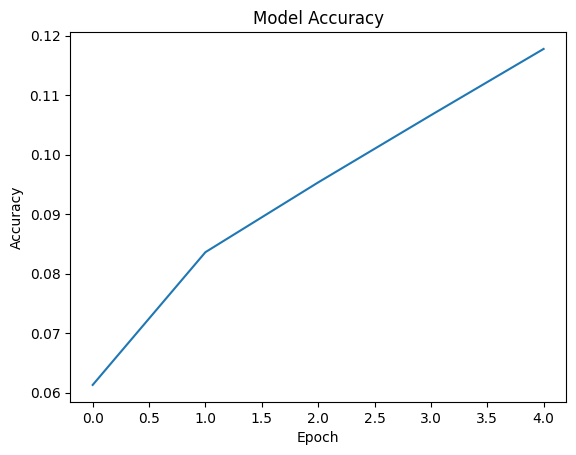

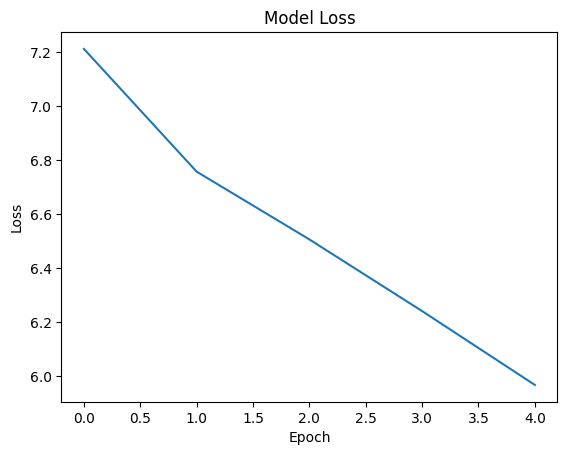

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history1.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()
plt.plot(history1.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')



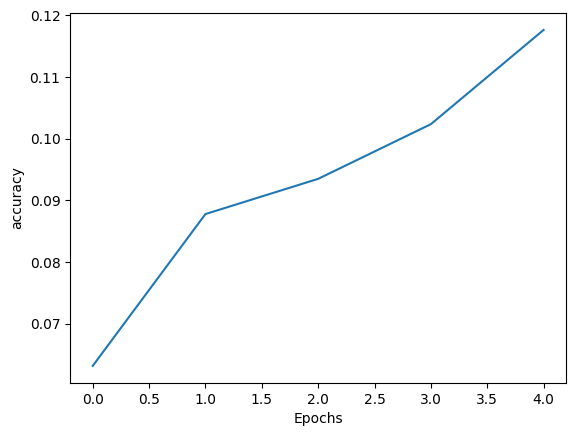

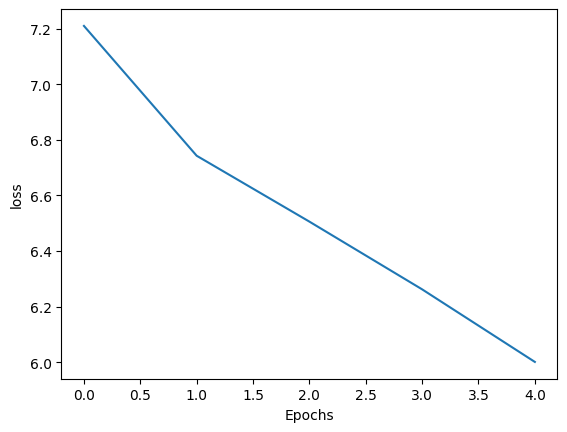

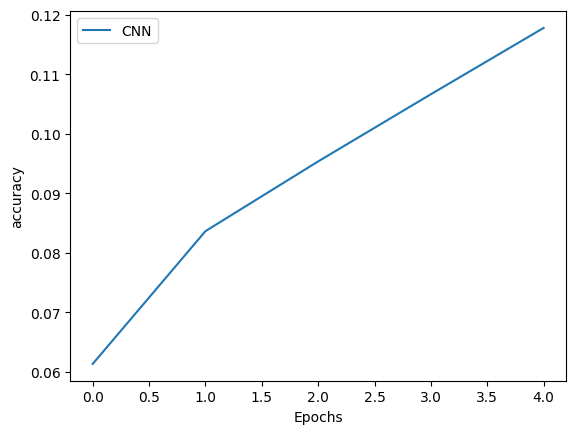

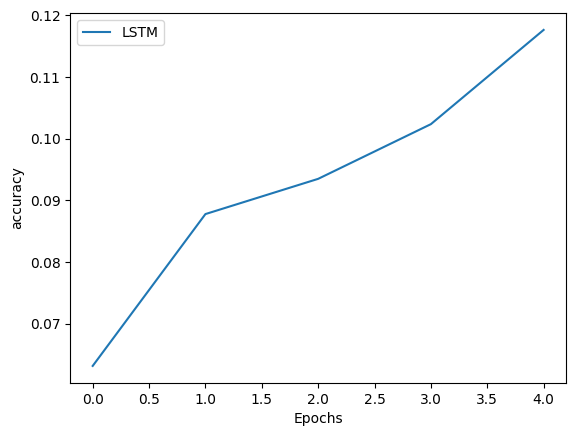

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have 'history_cnn' and 'history_lstm' objects for CNN and LSTM models

# Function to plot graphs
def plot_graphs(history, string, model_name):
    plt.plot(history.history[string], label=model_name)
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend()
    plt.show()

# Plotting accuracy graphs
plot_graphs(history1, 'accuracy', 'CNN')
plot_graphs(history, 'accuracy', 'LSTM')


In [ ]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences

# Assuming you have a trained tokenizer and the maximum sequence length (max_sequence_len) is defined
# tokenizer = ...  # Make sure this is defined and trained
# max_sequence_len = ...  # Define the maximum sequence length

seed_text = "our project is"
next_words = 1



for _ in range(next_words):
    # Convert the seed text to a sequence of tokens
    token_list = tokenizer.texts_to_sequences([seed_text])[0]

    # Pad the sequence to match the model's input length
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

    # Get the predicted probabilities for the next word
    predicted_probabilities = model.predict(token_list, verbose=0)

    # Get the index of the word with the highest probability
    predicted_class = np.argmax(predicted_probabilities)

    output_word = ""

    # Invert the word_index to get the word from the index
    for word, index in tokenizer.word_index.items():
        if index == predicted_class:
            output_word = word
            break

    # Append the predicted word to the seed text
    seed_text += " " + output_word

print(seed_text)


our project is of
